In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import numpy as np

In [158]:
X_test = torch.load("X_test.pt")
X_train = torch.load("X_train.pt")
y_test = torch.load("y_test.pt")
y_train = torch.load("y_train.pt")

In [159]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
device

'mps'

In [167]:
class MyModel(nn.Module):
    def __init__(
        self,
        dataloader: DataLoader,
        input_dim: int,
        output_dim: int = 1,
        dropout_rate: float = 0.5,
    ):
        super(MyModel, self).__init__()
        self.dataloader = dataloader
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=384, kernel_size=3, stride=1, padding=2)
        self.maxpooling1d = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.last_linear = nn.Linear(384, output_dim)
        self.sigmoid = nn.Sigmoid()

        self.to(device)

    def forward(self, x: torch.Tensor):
        if len(x.shape) == 2:  # Если x имеет размерность [batch_size, sequence_length]
            x = x.unsqueeze(1)  # Добавляем измерение каналов: [batch_size, 1, sequence_length]
        x = x.permute(0, 2, 1)  # [batch_size, input_dim, sequence_length]
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # Возвращаем размерность [batch_size, sequence_length, features]
        x = self.last_linear(x)
        x = self.sigmoid(x)
        return x

    def fit(
        self,
        num_epoch: int = 10,
        lr: float = 1e-10,
    ):
        self.epoch_loss = []
        self.batch_loss = []
        self.f1_score = []
        self.all_labels = []
        self.all_probs = []
        criterion = nn.BCELoss()  # Бинарная кросс-энтропия
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(num_epoch):
            self.train()
            epoch_losses = []
            for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; learning state\t"):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss: torch.Tensor = criterion(outputs.squeeze(1), batch_y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
                self.batch_loss.append(loss.item())
            
            self.epoch_loss.append(sum(epoch_losses) / len(epoch_losses))
            
            # Вычисление метрик
            self.eval()
            with torch.no_grad():
                self.all_preds = []
                self.all_labels = []
                for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; metric state\t"):
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = self(batch_X).squeeze(1)
                    preds = (outputs > 0.5).float()
                    self.all_preds.extend(preds.squeeze(1).cpu().numpy())
                    self.all_labels.extend(batch_y.cpu().numpy())

                self.all_labels = np.array(self.all_labels, dtype=int)
                self.all_preds = np.array(self.all_preds, dtype=int)
                f1 = f1_score(self.all_labels, self.all_preds)
                self.f1_score.append(f1)
                print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}, F1 score: {f1:.5f}")
    
    def plot_metrics(self):
        # График лосса
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.epoch_loss, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per Epoch")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.batch_loss, label="Loss")
        plt.xlabel("Batches")
        plt.ylabel("Loss")
        plt.title("Loss per batch")
        plt.legend()

        # График F1-score
        plt.subplot(1, 3, 3)
        plt.plot(self.f1_score, label="F1-score", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("F1-score")
        plt.title("F1-score per Epoch")
        plt.legend()

In [164]:
# не изменные константы для модельки
input_dim = X_train.shape[1]
output_dim = 1
dataset = TensorDataset(X_train, y_train.float())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch [1/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 488.31it/s]


Epoch [1/10], Loss: 0.7150, F1 score: 0.27042


Epoch [2/10]; metric state	: 100%|██████████| 6106/6106 [00:15<00:00, 384.62it/s]


Epoch [2/10], Loss: 0.7089, F1 score: 0.27035


Epoch [3/10]; metric state	: 100%|██████████| 6106/6106 [00:15<00:00, 393.20it/s]


Epoch [3/10], Loss: 0.6929, F1 score: 0.27016


Epoch [4/10]; metric state	: 100%|██████████| 6106/6106 [00:16<00:00, 365.04it/s]


Epoch [4/10], Loss: 0.6917, F1 score: 0.27012


Epoch [5/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 505.06it/s]


Epoch [5/10], Loss: 0.7025, F1 score: 0.27003


Epoch [6/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 490.64it/s]


Epoch [6/10], Loss: 0.6957, F1 score: 0.26999


Epoch [7/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 453.36it/s]


Epoch [7/10], Loss: 0.7054, F1 score: 0.26987


Epoch [8/10]; metric state	: 100%|██████████| 6106/6106 [00:14<00:00, 423.16it/s]


Epoch [8/10], Loss: 0.6986, F1 score: 0.26985


Epoch [9/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 469.86it/s]


Epoch [9/10], Loss: 0.7069, F1 score: 0.26976


Epoch [10/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 498.35it/s]


Epoch [10/10], Loss: 0.7039, F1 score: 0.26963


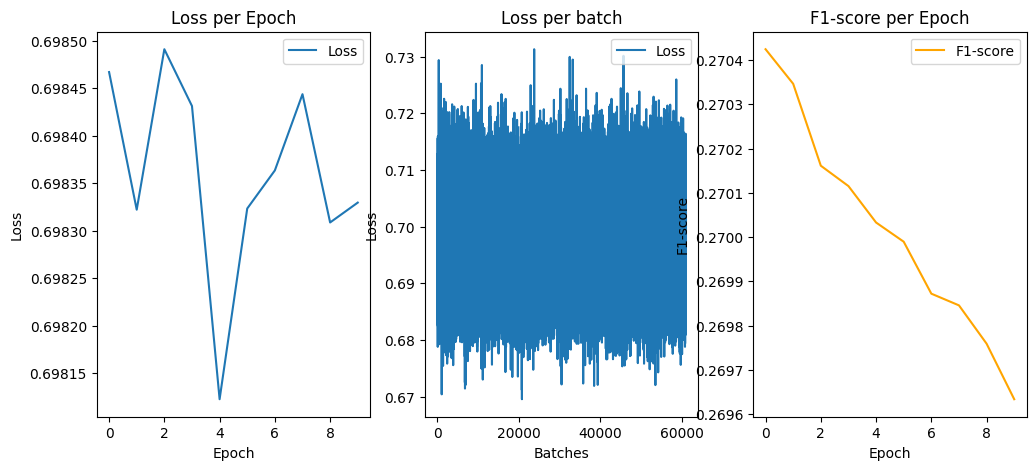

In [165]:
dropout_rate = 0.5

model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit()
model.plot_metrics()

Epoch [1/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 445.77it/s]


Epoch [1/10], Loss: 0.1991, F1 score: 0.76359


Epoch [2/10]; metric state	: 100%|██████████| 6106/6106 [00:11<00:00, 513.98it/s]


Epoch [2/10], Loss: 0.2105, F1 score: 0.79348


Epoch [3/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 505.68it/s]


Epoch [3/10], Loss: 0.0697, F1 score: 0.79960


Epoch [4/10]; metric state	: 100%|██████████| 6106/6106 [00:11<00:00, 525.11it/s]


Epoch [4/10], Loss: 0.3167, F1 score: 0.82307


Epoch [5/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 476.59it/s]


Epoch [5/10], Loss: 0.0289, F1 score: 0.83582


Epoch [6/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 446.20it/s]


Epoch [6/10], Loss: 0.3120, F1 score: 0.82603


Epoch [7/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 437.95it/s]


Epoch [7/10], Loss: 0.0529, F1 score: 0.85139


Epoch [8/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 455.16it/s]


Epoch [8/10], Loss: 0.4339, F1 score: 0.86121


Epoch [9/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 441.61it/s]


Epoch [9/10], Loss: 0.1150, F1 score: 0.87593


Epoch [10/10]; metric state	: 100%|██████████| 6106/6106 [00:20<00:00, 292.07it/s]


Epoch [10/10], Loss: 0.0412, F1 score: 0.88249


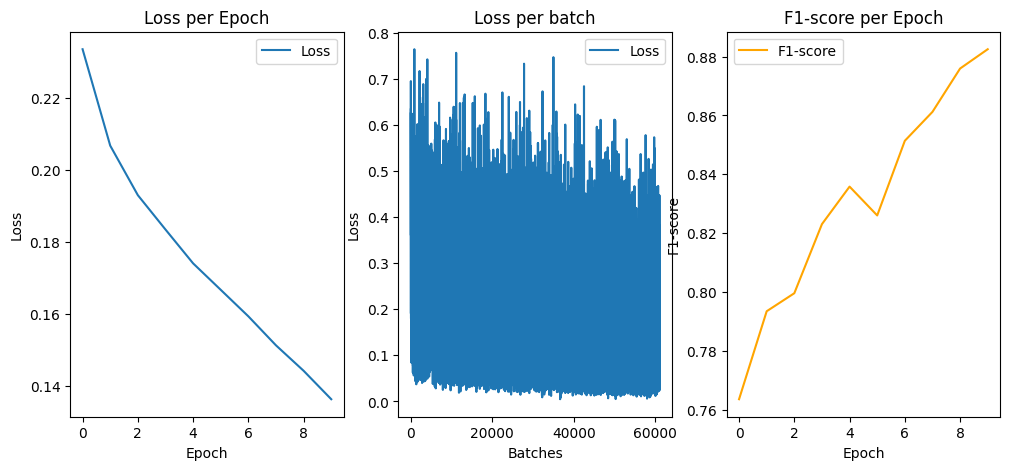

In [166]:
dropout_rate = 0.2
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics()

Epoch [1/10]; metric state	: 100%|██████████| 1527/1527 [00:16<00:00, 92.16it/s] 


Epoch [1/10], Loss: 0.1432, F1 score: 0.73529


Epoch [2/10]; metric state	: 100%|██████████| 1527/1527 [00:10<00:00, 141.86it/s]


Epoch [2/10], Loss: 0.2005, F1 score: 0.75177


Epoch [3/10]; metric state	: 100%|██████████| 1527/1527 [00:14<00:00, 102.55it/s]


Epoch [3/10], Loss: 0.3622, F1 score: 0.76760


Epoch [4/10]; metric state	: 100%|██████████| 1527/1527 [00:08<00:00, 179.19it/s]


Epoch [4/10], Loss: 0.1812, F1 score: 0.79356


Epoch [5/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 206.08it/s]


Epoch [5/10], Loss: 0.2806, F1 score: 0.80395


Epoch [6/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 210.24it/s]


Epoch [6/10], Loss: 0.1650, F1 score: 0.80852


Epoch [7/10]; metric state	: 100%|██████████| 1527/1527 [00:08<00:00, 171.72it/s]


Epoch [7/10], Loss: 0.2264, F1 score: 0.81696


Epoch [8/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 192.47it/s]


Epoch [8/10], Loss: 0.3197, F1 score: 0.82820


Epoch [9/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 210.97it/s]


Epoch [9/10], Loss: 0.2125, F1 score: 0.83590


Epoch [10/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 210.32it/s]


Epoch [10/10], Loss: 0.1049, F1 score: 0.84004


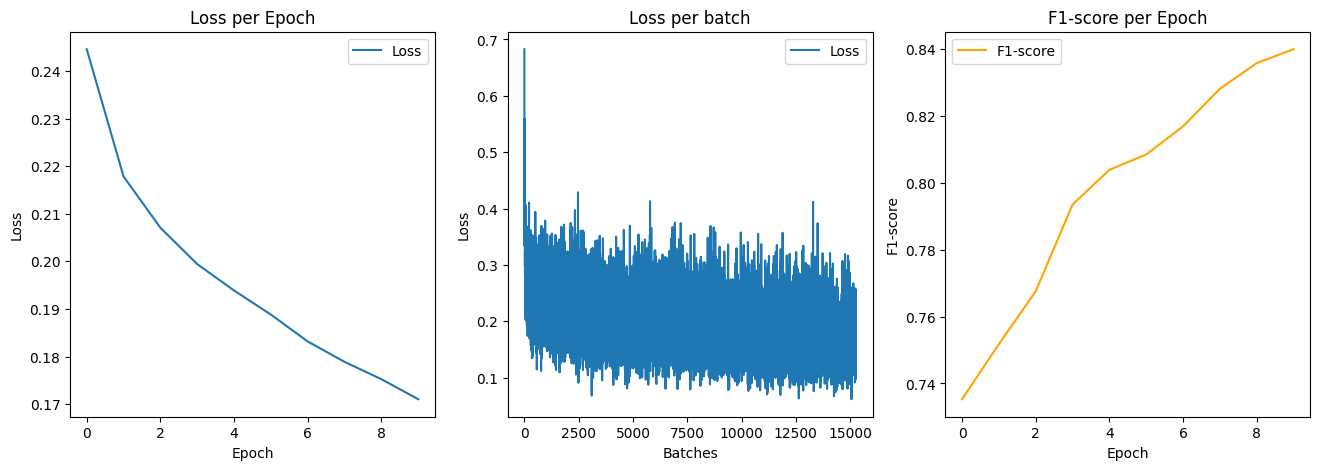

In [168]:
dropout_rate = 0.5
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics()

Epoch [1/10]; metric state	: 100%|██████████| 382/382 [00:08<00:00, 45.92it/s]


Epoch [1/10], Loss: 0.2409, F1 score: 0.74264


Epoch [2/10]; metric state	: 100%|██████████| 382/382 [00:07<00:00, 47.98it/s]


Epoch [2/10], Loss: 0.2114, F1 score: 0.75817


Epoch [3/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 70.64it/s]


Epoch [3/10], Loss: 0.2083, F1 score: 0.78572


Epoch [4/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 74.25it/s]


Epoch [4/10], Loss: 0.1369, F1 score: 0.79233


Epoch [5/10]; metric state	: 100%|██████████| 382/382 [00:06<00:00, 62.94it/s]


Epoch [5/10], Loss: 0.2302, F1 score: 0.79005


Epoch [6/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 72.90it/s]


Epoch [6/10], Loss: 0.2351, F1 score: 0.80642


Epoch [7/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 75.33it/s]


Epoch [7/10], Loss: 0.2396, F1 score: 0.81820


Epoch [8/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 72.36it/s]


Epoch [8/10], Loss: 0.1688, F1 score: 0.82053


Epoch [9/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 75.78it/s]


Epoch [9/10], Loss: 0.1495, F1 score: 0.83291


Epoch [10/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 73.15it/s]


Epoch [10/10], Loss: 0.2150, F1 score: 0.83455


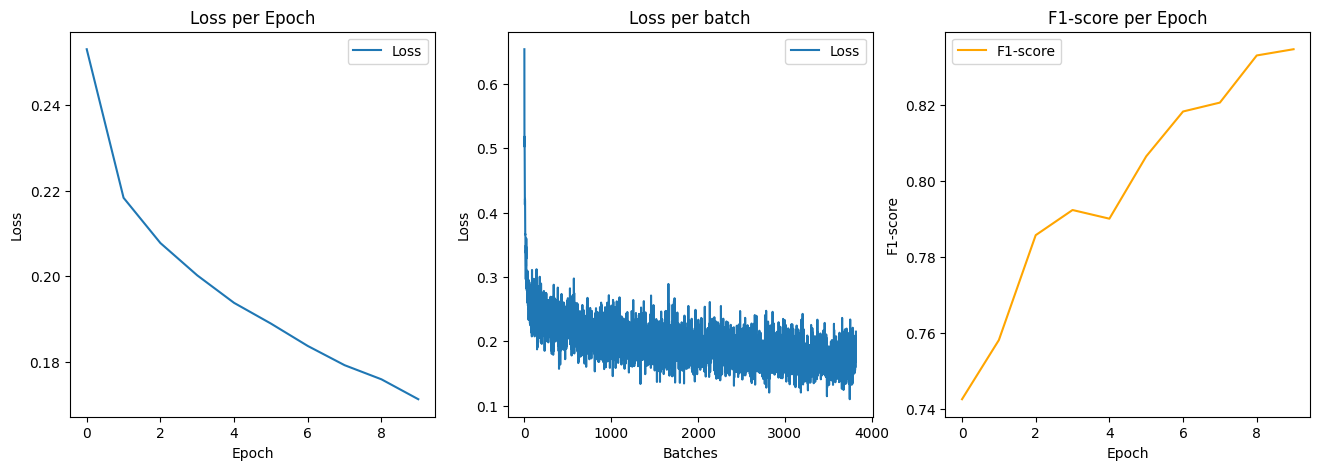

In [171]:
dropout_rate = 0.5
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics()

Epoch [1/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.25it/s]


Epoch [1/25], Loss: 0.2250, F1 score: 0.74580


Epoch [2/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.20it/s]


Epoch [2/25], Loss: 0.2263, F1 score: 0.76189


Epoch [3/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.24it/s]


Epoch [3/25], Loss: 0.2077, F1 score: 0.77304


Epoch [4/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.58it/s]


Epoch [4/25], Loss: 0.1823, F1 score: 0.78932


Epoch [5/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.24it/s]


Epoch [5/25], Loss: 0.1798, F1 score: 0.80256


Epoch [6/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 34.37it/s]


Epoch [6/25], Loss: 0.2094, F1 score: 0.78979


Epoch [7/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.37it/s]


Epoch [7/25], Loss: 0.1535, F1 score: 0.79519


Epoch [8/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.41it/s]


Epoch [8/25], Loss: 0.1799, F1 score: 0.82245


Epoch [9/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.40it/s]


Epoch [9/25], Loss: 0.1577, F1 score: 0.83839


Epoch [10/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.33it/s]


Epoch [10/25], Loss: 0.1666, F1 score: 0.84390


Epoch [11/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 34.10it/s]


Epoch [11/25], Loss: 0.1470, F1 score: 0.85590


Epoch [12/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 33.02it/s]


Epoch [12/25], Loss: 0.1258, F1 score: 0.86357


Epoch [13/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.45it/s]


Epoch [13/25], Loss: 0.1363, F1 score: 0.86816


Epoch [14/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.24it/s]


Epoch [14/25], Loss: 0.1118, F1 score: 0.87798


Epoch [15/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 34.16it/s]


Epoch [15/25], Loss: 0.1344, F1 score: 0.88077


Epoch [16/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 33.28it/s]


Epoch [16/25], Loss: 0.1252, F1 score: 0.88817


Epoch [17/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 33.41it/s]


Epoch [17/25], Loss: 0.1219, F1 score: 0.87956


Epoch [18/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 34.11it/s]


Epoch [18/25], Loss: 0.1173, F1 score: 0.89509


Epoch [19/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.96it/s]


Epoch [19/25], Loss: 0.1056, F1 score: 0.88641


Epoch [20/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 34.79it/s]


Epoch [20/25], Loss: 0.1227, F1 score: 0.91420


Epoch [21/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.16it/s]


Epoch [21/25], Loss: 0.1044, F1 score: 0.92347


Epoch [22/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.88it/s]


Epoch [22/25], Loss: 0.1075, F1 score: 0.92185


Epoch [23/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.09it/s]


Epoch [23/25], Loss: 0.1070, F1 score: 0.93377


Epoch [24/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.42it/s]


Epoch [24/25], Loss: 0.1047, F1 score: 0.93397


Epoch [25/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.31it/s]


Epoch [25/25], Loss: 0.0904, F1 score: 0.94420


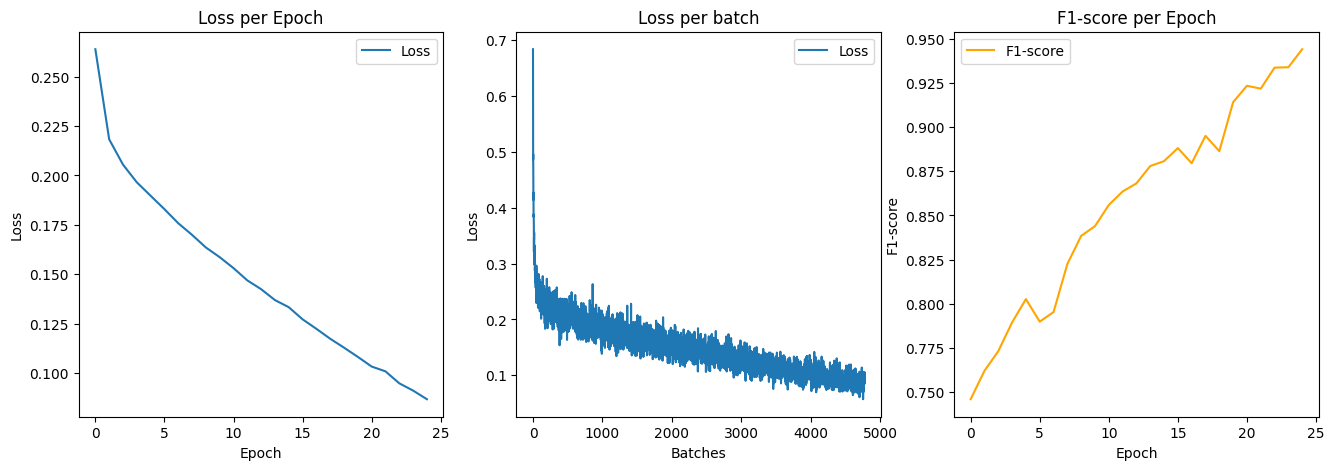

In [172]:
dropout_rate = 0.2
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3, num_epoch=25)
model.plot_metrics()

In [ ]:
preds = model.forward(X_test)

RuntimeError: Mismatched Tensor types in NNPack convolutionOutput